# Geographic Correlation to POI: air temperature (reanalysis) and precipitation (GPCC)

Calculate correlation between geographic points surrounding St. Louis, MO for chosen environmental variables. 

#### import packages

In [1]:
import env_methods as em 
import vis_methods as vm 
import time 
import numpy as np
import copy
import matplotlib.pyplot as plt 
import cartopy 
import cartopy.crs as ccrs 


#### initial parameters 

In [2]:
st_lou = [38.611389, -90.203154] #lat/lon coords of a taco joint in st. lou
#standard longitude system = -degrees east of prime meridian, +degrees west of prime meridian (GPCC stores data this way 

#bounding box - North America
lat_start = 60
lat_end = 0
lon_start = -180
lon_end =  -20

#whold world bouding box 
lat_start = 90
lat_end = -90
lon_start = -180
lon_end =  180

#files containing data 
gpcc_dir = r'D:\GPCC'
air_dir = r'D:\NOAA - just air'
mois_dir = r'D:\NOAA Reanalysis Data\Soil'

#### import data

In [3]:
start_time = time.time()
pre_dic = em.get_data_gpcc(gpcc_dir, 1) #1 degree resolution, can't handle 0.25 deg res 
print("--- %s seconds for GPCC ---" % (time.time() - start_time))

--- 39.591395139694214 seconds for GPCC ---


__NOTE__: All NCEP reanalysis datasets are stored in 0 to 360 deg longitude sets, representing degrees west of the dateline 

In [4]:
start_time = time.time()
air_dic = em.get_data(air_dir, True, [0]) #1 degree resolution, can't handle 0.25 deg res 
air = air_dic['nc_vars']['air']
air_dic['air'] = air_dic.pop('nc_vars') #get rid of stacked structure 
air_dic['air'] = air
print("--- %s seconds for air temp ---" % (time.time() - start_time))

acquring data from air.sfc.mon.mean.nc
--- 2.3262288570404053 seconds for air temp ---


In [5]:
start_time = time.time()
mois_dic = em.get_data(mois_dir, True, [0])
soilm = mois_dic['nc_vars']['soilm']
mois_dic['soilm'] = mois_dic.pop('nc_vars')
soilm[soilm == 9.96921E36] = np.nan
soilm[soilm == -9.96921E36] = np.nan
mois_dic['soilm'] = soilm
print("--- %s seconds for soil moisture ---" % (time.time() - start_time))

acquring data from soilm.mon.mean.nc
--- 1.6491889953613281 seconds for soil moisture ---


In [6]:
def compress2annual(dp, var):
    num_years = dp['time'][-1].year - dp['time'][0].year + 1 
    new_data = np.empty((num_years, dp[var].shape[1], dp[var].shape[2]))
    time_new = np.arange(dp['time'][0].year, dp['time'][-1].year + 1).tolist()

    for y in time_new: 
        inds = em.get_year_indices(dp['time'], y)
        arr = np.mean(dp[var][inds, :, : ], axis = 0)
        
        new_data[time_new.index(y), :, :] = arr
    
    dp['time'] = time_new
    dp[var] = new_data
    
    return dp 

air_dic = compress2annual(copy.deepcopy(air_dic), 'air')
pre_dic = compress2annual(copy.deepcopy(pre_dic), 'precip')
mois_dic = compress2annual(copy.deepcopy(mois_dic), 'soilm')

#### geospatial correlation method

In [7]:
#method to generate a correlation grid 
#assume grid = time x lat x lon 
def corr_grid(array, poi): #poi refers to indices 
    corr = np.empty([array.shape[1], array.shape[2]])
    comp = array[:, poi[0], poi[1]] #time series at poi 
    for i in range(array.shape[1]):
        for j in range(array.shape[2]):
            comp0 = array[:, i, j]
            corr[i, j] = np.corrcoef(comp, comp0)[0,1]
    return corr

#### run correlation on each dictionary 

In [8]:
start_time = time.time()
dics = [pre_dic, air_dic, mois_dic]
name = ['precip', 'air', 'soilm']
c = []

for i in range(len(dics)):
    d = dics[i]

    poi = [em.find_closest_val(st_lou[0], d['lat']), em.find_closest_val(st_lou[1], d['lon'])]
    
    #conversion
    if i > 0: 
        if st_lou[1] < 0: 
            poi = [em.find_closest_val(st_lou[0], d['lat']), em.find_closest_val(360 + st_lou[1], d['lon'])] 
        if st_lou[1] > 0:
            poi = [em.find_closest_val(st_lou[0], d['lat']), em.find_closest_val(st_lou[1], d['lon'])] 
    print(poi)
    c.append(corr_grid(d[name[i]], poi))
    

print("--- %s seconds for correlation  ---" % (time.time() - start_time))

[51, 89]
[26, 144]
[26, 144]
--- 21.920554637908936 seconds for correlation  ---


[0, 359]
[180, -180]
[0, 191]
[180, -180]
[0, 191]


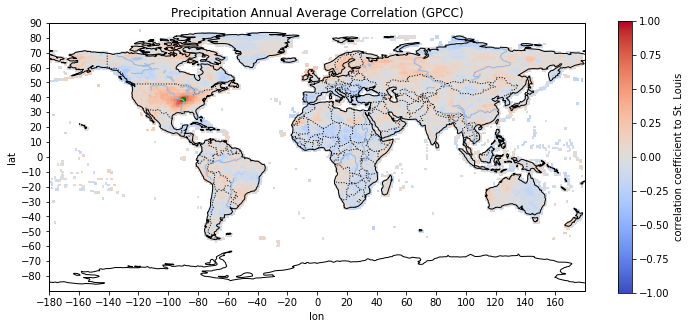

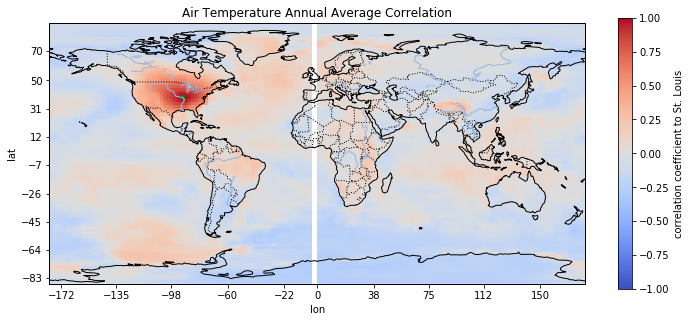

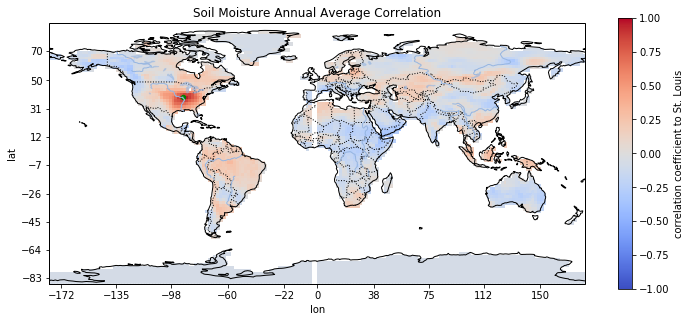

In [9]:

def plot_corr(dic, array, title, lat_start, lat_end, lon_start, lon_end, poi, flipped_axis):
    lat = dic['lat']
    lon = dic['lon']
    
    old_lon = lon 
    if flipped_axis:
        lon = [180 - x for x in lon]
        temp = lon_start
        lon_start = lon_end
        lon_end = temp
        
        #print(lon)
        print([lon_start, lon_end])
        
    fig = plt.figure(figsize = (12, 5))
    fig.patch.set_facecolor('white')
        
    ax = plt.subplot(projection = ccrs.PlateCarree(central_longitude = 0))
    lat1 = em.find_closest_val(lat_start, lat)
    lat2 = em.find_closest_val(lat_end, lat)
    lon1 = em.find_closest_val(lon_start, lon)
    lon2 = em.find_closest_val(lon_end, lon)
    
    print([lon1, lon2])
    ax.coastlines()
    plt.title(title)
    plt.xlabel('lon')
    plt.ylabel('lat')
    
    ax.set_xticks(np.round(np.asarray(old_lon[lon1:lon2][::20])), crs = ccrs.PlateCarree())
    ax.set_yticks(np.round(np.asarray(lat[lat1:lat2][::10])), crs = ccrs.PlateCarree())
        
    mesh = plt.pcolormesh(old_lon[lon1:lon2], lat[lat1:lat2], array[lat1:lat2,lon1:lon2], cmap = 'coolwarm', vmax = 1, vmin = -1)
    cbar = plt.colorbar(mesh)
    plt.scatter(poi[1], poi[0], color = 'green', s = 20, transform=ccrs.PlateCarree())
    cbar.set_label('correlation coefficient to St. Louis')
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax.add_feature(cartopy.feature.RIVERS)
    
    

plot_corr(pre_dic, c[0], 'Precipitation Annual Average Correlation (GPCC)', lat_start, lat_end, lon_start, lon_end, copy.copy(st_lou), False)
plot_corr(air_dic, c[1], 'Air Temperature Annual Average Correlation', lat_start, lat_end,lon_start, lon_end, copy.copy(st_lou), True)
plot_corr(mois_dic, c[2], 'Soil Moisture Annual Average Correlation', lat_start, lat_end, lon_start, lon_end, copy.copy(st_lou), True)

In [10]:
def write_csv():
    keys = ['soilm', 'air']
    index = 0 
    list_lat = []
    list_lon = []
    list_val = []
    for d in precip_dic, mois_dic, air_dic:
        lat = d['lat']
        lon = d['lon']
        for i in range(len(lat)):
            nlat = lat[i]
            for j in range(len(lon)):
                nlon = lon[i]
                val = key[index][i,j]
        index = index + 1
